# Optimisation using the CMA evolutionary strategy

This notebook will explain how to optimise a model using the covariance matrix adaptation (CMA) optimisation strategy. 
BluePyOpt includes two flavors of CMA: a single objective one and a hybrid single/multi objective one.

For a tutorial on the theory and algorithm behind CMA, please refer to https://arxiv.org/abs/1604.00772.

This notebook uses the simple cell model defined in examples/simplecell. Please refer to this notebook for a first introduction to model fitting.

In [1]:
# Install matplotlib if needed
!pip install matplotlib

You should consider upgrading via the '/gpfs/bbp.cscs.ch/ssd/apps/tools/jupyter/venvs/python37/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy

%load_ext autoreload
%autoreload

In [3]:
def plot_fitness(logbook):
    gen_numbers = logbook.select('gen')
    min_fitness = logbook.select('min')
    max_fitness = logbook.select('max')
    plt.plot(gen_numbers, min_fitness, label='min fitness')
    plt.xlabel('generation #')
    plt.ylabel('score (# std)')
    plt.legend()
    plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
    plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 

In [4]:
def plot_responses(responses):
    plt.subplot(2,1,1)
    plt.plot(responses['step1.soma.v']['time'], responses['step1.soma.v']['voltage'], label='step1')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(responses['step2.soma.v']['time'], responses['step2.soma.v']['voltage'], label='step2')
    plt.legend()
    plt.tight_layout()

Setting up the cell template and evaluator
-------------------------

First, we instantiate the cell template and evaluator as defined in the simplecell example:

In [6]:
import bluepyopt.ephys.examples.simplecell

simple_cell = bluepyopt.ephys.examples.simplecell.SimpleCell()
evaluator = simple_cell.cell_evaluator

Optimisation using single objective CMA (SO-CMA)
-------------------------

First we will present the single objective version of the CMA strategy.

In this version of CMA, the optimizer aims at minimizing a single fitness value computed as the sum of the scores of the objectives.

Note that in CMA, informing the offspring_size is optional as by default, it is automatically set to
int(4 + 3 * log(dimension_parameter_space)).

In [53]:
optimiser = bluepyopt.deapext.optimisationsCMA.DEAPOptimisationCMA
optimisation = optimiser(evaluator=evaluator, seed=1)
pop, hof, log, hist = optimisation.run(max_ngen=10)

In [54]:
best_ind = hof[0]
print('Best individual: ', best_ind)
print('Fitness values: ', best_ind.fitness.values)

Best individual:  [0.11513442416272959, 0.038816802452611765]
Fitness values:  (0.0,)


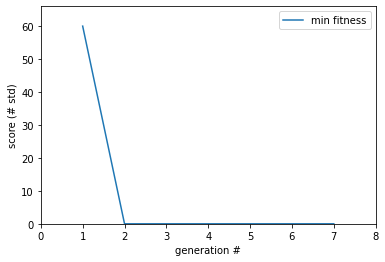

In [55]:
plot_fitness(log)

If one wishes to optimize starting form a known solution, or fine-tune a past mdodel, the argument `centroid` can be used to initialise the center of the CMA search. In this case, it might be useful to also specify `sigma`, which is the initial standard deviation of the distribution from which the models are drawn.

For example here,we can restart from the final results of the previous optimisation:

In [56]:
optimisation = optimiser(centroids=[list(hof[0])], sigma=0.01, evaluator=evaluator, seed=2)
pop, hof, log, hist = optimisation.run(max_ngen=10)

In [57]:
best_ind = hof[0]
print('Best individual: ', best_ind)
print('Fitness values: ', best_ind.fitness.values)

Best individual:  [0.11485248564327624, 0.039145905479049836]
Fitness values:  (0.0,)


Optimisation using multi objective CMA (MO-CMA)
-------------------------

Second is the hybrid single/multi objective CMA strategy. It is tasked with both:
- minimizing the fitness computed as the sum of the scores 
- maximizing the hyper-volume of the Pareto front formed by the current population of models.

At each generation, all models in the population are ranked for both criteria, and a mixed rank is obtained following the formula:

rank_mixed = w_hv * rank_hv. + ((1 - w_hv) * rank_fitness).

Following this ranking, the best models are selected to update the CMA kernel for the next generation.

By default, the weight assigned to the hyper-volume ranking (w_hv) is set to 0.5. The case w_hv=1  would lead to a pure multi-objective optimisation aiming at maximizing the hypervolume while w_hv would aim at minimizing the raw fitness (note that in the latter, the result would differ from using the SO-CMA as the MO-CMA uses a slightly different evolutionary logic).

In [58]:
optimisation = optimiser(weight_hv=0.5, offspring_size=3, selector_name="multi_objective", evaluator=evaluator, seed=2)
pop, hof, log, hist = optimisation.run(max_ngen=10)

In [59]:
best_ind = hof[0]
print('Best individual: ', best_ind)
print('Fitness values: ', best_ind.fitness.values)

Best individual:  [0.11309639259118459, 0.034266363909519156]
Fitness values:  (0.0,)


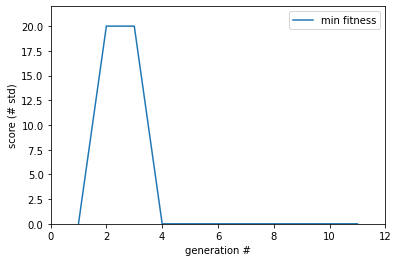

In [60]:
plot_fitness(log)

CMA versus IBEA 
-------------------------

As the present package proposes both the IBEA and CMA evolutionary strategies, one might ask: Which one is the best?

Unfortunately, there is no definitive answer to this question.

From a theoretical point of view, the advantages of the CMA strategy seem strong:
- In IBEA, the creation of a new generation is performed through random mating and mutation. However, due to the lack of a learning rate, this leads to a lack of convergence in the latter stage of the optimisation as the models will jump around an optimal solution without being able to reach it. In CMA, the `sigma` parameter, which is the width of the distribution from which the models should be drawn, decreases once the optimisation finds a bassin in the fitness landscape, leading to smoother convergence.
- In IBEA, as the new generation only depends on the latest one, the knowledge contained in the previous generations is almost completely lost. In CMA, the covariance matrix continuously evolves, taking into account the results of each generation, leading to an accumulation of past knowledge about the shape of the local fitness landscape.
- The ideal CMA population size, computed as int(4 + 3 * log(dimension_parameter_space)) is often one or two order of magnitude smaller than the population size needed by IBEA to reach the same results. This results in less compute per generation for the CMA strategy.

However, CMA is not without drawbacks:
- It is frequent for the CMA strategy (especially the SO-CMA) to converge too quickly and thus get stuck in sub-optimal minima. Therefore, to achieve the exploration level displayed by the IBEA strategy, it might be needed to run several CMA optimisations in parallel and pool the results.
- Although the population size is much smaller when using the CMA strategy, a proper convergence might require many more generations than for the IBEA strategy, thus nullifying the advantage of the small generation in term of compute.

Overall, CMA makes a more clever use of the information available, but IBEA is not to be neglected, especially if more compute power is available.